<a href="https://colab.research.google.com/github/alvarodca/LLM/blob/main/AppendixD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **APPENDIX D**

In this appendix, we enhance the training function for the pretraining and finetuning processes covered in chapters 5 to 7

In particular, it covers learning rate warmup, cosine decay, and gradient clipping



In [1]:
import torch
import torch.nn as nn

In [2]:
# Multi Head attention
class MultiHeadAttention(nn.Module):
 def __init__(self, d_in, d_out,
    context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()

    assert (d_out % num_heads == 0), \
    "d_out must be divisible by num_heads" # We need dimensions to align as we may lose dimensions in the process if not.

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads # Makes sure each attention head has equal dimensions

    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out) # Layer to combine outpute
    self.dropout = nn.Dropout(dropout)

    self.register_buffer(
    "mask",
    torch.triu(torch.ones(context_length, context_length),
    diagonal=1)
    )


 def forward(self, x):
    b, num_tokens, d_in = x.shape # b <- batch size, num_tokens <- sequence length, d_in <- input embedding

    # shape = [b,num_tokens, d_out] where d_out = num_heads * head_dim
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    # Split the values into Heads, shape = [b, num_tokens, num_heads, head_dim]
    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(
    b, num_tokens, self.num_heads, self.head_dim
    )

    # As we are using nn.Linear we need to transpose our matrices
    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2)

    # Computes dot product for each head
    attn_scores = queries @ keys.transpose(2, 3)

    # Masking
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]  # Mask fixed to token number
    attn_scores.masked_fill_(mask_bool, -torch.inf) # Uses mask to fill attention scores

    # Softmax + Dropout
    attn_weights = torch.softmax(
    attn_scores / keys.shape[-1]**0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)

    # Context vector
    context_vec = (attn_weights @ values).transpose(1, 2)

    # Combine all heads
    context_vec = context_vec.contiguous().view(
    b, num_tokens, self.d_out
    )
    # Mix information to a single simple layer
    context_vec = self.out_proj(context_vec)
    return context_vec

In [3]:
# Text generator
def generate_text_simple(model, idx,
    max_new_tokens, context_size):
    # Uses only the maximum amount of selected tokens
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # Takes the selected tokens as input
        with torch.no_grad(): # No gradient calculating (prediction)
            logits = model(idx_cond) # Output prediction

        logits = logits[:, -1, :] # Logits for the last token (predicting the last wrod)
        probas = torch.softmax(logits, dim=-1) # Values to probabilities (softmax) not strictly necessary
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) # Selects the highest value
        idx = torch.cat((idx, idx_next), dim=1) # Appends to the previous tokens
    return idx

# GELU
class GELU(nn.Module):
 def __init__(self):
    super().__init__()

 def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
    torch.sqrt(torch.tensor(2.0 / torch.pi)) *
    (x + 0.044715 * torch.pow(x, 3))
    ))

# FEED FORWARD
class FeedForward(nn.Module):
 def __init__(self, cfg):
    super().__init__()
    # Neural layers
    self.layers = nn.Sequential(
    nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), # Increases embedding by 4
    GELU(),
    nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), # Decreases embedding by 4
    )
 def forward(self, x):
    return self.layers(x)

# TRANSFORMER BLOCK
class TransformerBlock(nn.Module):
 def __init__(self, cfg):
    super().__init__()
    """Init method
        d_in = input embedding size
        d_out = output embedding size
        context_length = max number of tokens in a sentence
        num_heads = number of heads to use
        dropout = droput rate
        qkv_bias = whether to add bias"""
    self.att = MultiHeadAttention(
    d_in=cfg["emb_dim"],
    d_out=cfg["emb_dim"],
    context_length=cfg["context_length"],
    num_heads=cfg["n_heads"],
    dropout=cfg["drop_rate"],
    qkv_bias=cfg["qkv_bias"])

    # FeedForward structure
    self.ff = FeedForward(cfg)

    # Normalizes inputs before the different blocks <- PreLayerNorm
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])

    # Dropout layer
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

 def forward(self, x): # Enables shortcut connections

    # FIrst block of our previously shown picture
    shortcut = x
    x = self.norm1(x) # Normalize input
    x = self.att(x) # Self-attention
    x = self.drop_shortcut(x) # Dropout
    x = x + shortcut # Residual connection

    # Second block
    shortcut = x
    x = self.norm2(x) # Normalize
    x = self.ff(x) # FeedForward
    x = self.drop_shortcut(x) # Dropout
    x = x + shortcut # Residual
    return x


# LAYERNORM
class LayerNorm(nn.Module):
 def __init__(self, emb_dim): # emb_dim is the last dimension, to work with these numbers
    super().__init__()
    self.eps = 1e-5 # Small value to avoid division by 0
    # Trainable parameters
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

 def forward(self, x):
    # Applies normalization
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift


In [4]:
# GPT MODEL
class GPTModel(nn.Module):
 def __init__(self, cfg):
    super().__init__()
    # Token and positional embedding layers, convert tokens into vectors and add valuable information
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    # Sequential Stack of Transformer Block equal to the number of layers
    self.trf_blocks = nn.Sequential(
    *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

    # Layer Norm to standardize outputs
    self.final_norm = LayerNorm(cfg["emb_dim"])

    # Output into the vocabulary
    self.out_head = nn.Linear(
    cfg["emb_dim"], cfg["vocab_size"], bias=False
    )

 def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    # Computes embeddings
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(
    torch.arange(seq_len, device=in_idx.device)
    )
    # Adds embeddings
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x) # Dropout
    x = self.trf_blocks(x) # Transformer Blocks
    x = self.final_norm(x) # Normalization
    logits = self.out_head(x) # Output
    return logits




In [6]:
# Reinitializing the model
import torch


GPT_CONFIG_124M = {
 "vocab_size": 50257,
 "context_length": 256,
 "emb_dim": 768,
 "n_heads": 12,
 "n_layers": 12,
 "drop_rate": 0.1,
 "qkv_bias": False
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
model.eval()


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

Obtaining input data


In [10]:
import os
import urllib.request
file_path = "the-verdict.txt"
url = (
 "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/"
 "main/ch02/01_main-chapter-code/the-verdict.txt"
)
if not os.path.exists(file_path):
 with urllib.request.urlopen(url) as response:
  text_data = response.read().decode('utf-8')
 with open(file_path, "w", encoding="utf-8") as file:
  file.write(text_data)
else:
 with open(file_path, "r", encoding="utf-8") as file:
  text_data = file.read()

Loading data onto DataLoaders

In [11]:
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        """Init method
        txt: string input text
        tokenizer: turns text into tokens
        max_length: int length of each input sentence
        stride: step size between chunks, how far to move sliding window"""

        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt) # Tokenizes the entire text

        for i in range(0, len(token_ids) - max_length, stride): # Uses a sliding window
            input_chunk = token_ids[i:i + max_length] # Set of words of max length
            target_chunk = token_ids[i + 1: i + max_length + 1] # The next max length
            self.input_ids.append(torch.tensor(input_chunk)) # Stored as tensors
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids) # Returns the total number of rows from the dataset

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx] # Returns a single row from the dataset


def create_dataloader_v1(txt, batch_size=4, max_length=256,
    stride=128, shuffle=True, drop_last=True,
    num_workers=0):

    tokenizer = tiktoken.get_encoding("gpt2") # Tokenized

    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride) # Creates dataset

    dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    drop_last=drop_last, # True to avoid errors in training
    num_workers=num_workers
    )
    return dataloader

In [12]:
# Splitting data
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
torch.manual_seed(123)
train_loader = create_dataloader_v1(
 text_data[:split_idx],
 batch_size=2,
 max_length=GPT_CONFIG_124M["context_length"],
 stride=GPT_CONFIG_124M["context_length"],
 drop_last=True,
 shuffle=True,
 num_workers=0
)
val_loader = create_dataloader_v1(
 text_data[split_idx:],
 batch_size=2,
 max_length=GPT_CONFIG_124M["context_length"],
 stride=GPT_CONFIG_124M["context_length"],
 drop_last=False,
 shuffle=False,
 num_workers=0
)

**Learning Rate Warmup**

This process involves gradually increasing the learning rate from a very
low initial value (initial_lr) to a maximum value specified by the user (peak_lr).
Starting the training with smaller weight updates decreases the risk of the model
encountering large, destabilizing updates during its training phase.


Warmup steps refer to the number of training steps (or sometimes epochs) during which the learning rate is gradually increased from 0 (or a small value) to the target learning rate.

In [13]:
n_epochs = 15
initial_lr = 0.0001
peak_lr = 0.01
warmup_steps = 20

total_steps = len(train_loader) * n_epochs
warmup_steps = int(0.2 * total_steps)
print("Warmup steps:",warmup_steps)


Warmup steps: 27


This prints 27, meaning that we have 20 warmup steps to increase the initial learning
rate from 0.0001 to 0.01 in the first 27 training steps.

In [14]:
# Creates AdamW optimizer with weight decay
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)
# How much learning rate should increase per step during warmup
lr_increment = (peak_lr - initial_lr) / warmup_steps
# Optimizer steps taken
global_step = -1
# Stores learning rate at each step
track_lrs = []

# Loop through epochs and batches
for epoch in range(n_epochs):
 for input_batch, target_batch in train_loader:
  optimizer.zero_grad() # Gradients back to 0
  global_step += 1 # One more step

  # During warmup
  if global_step < warmup_steps:
    lr = initial_lr + global_step * lr_increment # Change in learning rate
  # After warmup
  else:
    lr = peak_lr

  # Sets the same lr for all parameters
  for param_group in optimizer.param_groups:
    param_group["lr"] = lr

  # Stores learning rate
  track_lrs.append(optimizer.param_groups[0]["lr"])

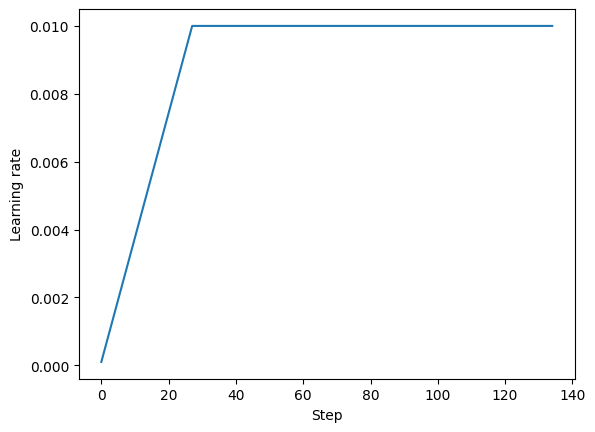

In [15]:
# Quick test of the code
import matplotlib.pyplot as plt
plt.ylabel("Learning rate")
plt.xlabel("Step")
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs);
plt.show()

Shows the warmup during the first 20 steps

Next, we will modify the learning rate further so that it decreases after reaching the
maximum learning rate, which further helps improve the model training

**Cosine Decay**

Cosine decay reduces the learning rate following a cosine curve, starting from a maximum learning rate and decaying smoothly to a minimum (often zero) by the end of training.

Smooth convergence

No abrupt drops

Often leads to better generalization and performance (especially in transformers and CNNs)

In [16]:
import math
min_lr = 0.1 * initial_lr
track_lrs = []
lr_increment = (peak_lr - initial_lr) / warmup_steps
global_step = -1


for epoch in range(n_epochs):
 for input_batch, target_batch in train_loader:
  optimizer.zero_grad()
  global_step += 1

  # Warmup
  if global_step < warmup_steps:
    lr = initial_lr + global_step * lr_increment
  else: # After warmup apply cosine
    progress = ((global_step - warmup_steps) /
    (total_training_steps - warmup_steps))
    lr = min_lr + (peak_lr - min_lr) * 0.5 * (
    1 + math.cos(math.pi * progress)
    )

  for param_group in optimizer.param_groups:
    param_group["lr"] = lr
  track_lrs.append(optimizer.param_groups[0]["lr"])

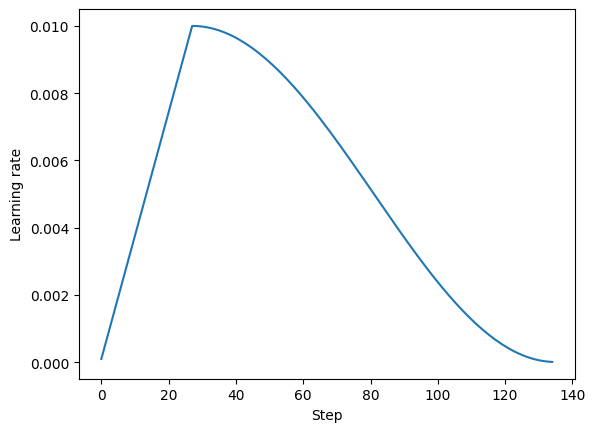

In [17]:
# Testing
plt.ylabel("Learning rate")
plt.xlabel("Step")
plt.plot(range(total_training_steps), track_lrs)
plt.show()

# We see a smooth decreasing curve

**Gradient Clipping**

This method involves setting a threshold above which gradients are downscaled to a predetermined maximum magnitude. This process ensures that the updates
to the model’s parameters during backpropagation stay within a manageable range.

In [18]:
# Using previous loss batches

# Cross entropy loss of a single batch
def calc_loss_batch(input_batch, target_batch, model, device):
 """ Input batch: batch of input data
 target batch: labels we wish to predict
 model: NN model
 device: CPU or GPU"""

 # Used more commonly for GPU
 input_batch = input_batch.to(device)
 target_batch = target_batch.to(device)

 # Output
 logits = model(input_batch)

 # Loss
 loss = torch.nn.functional.cross_entropy(
 logits.flatten(0, 1), target_batch.flatten()
 )
 return loss

# Loss over all batches
def calc_loss_loader(data_loader, model, device, num_batches=None):
 """ data_loader: DataLoader for providing batches of input
 model: evaluated model
 device: CPU or GPU
 num_batches: batches used to compute loss, if None, all batches are used"""

 # Initalize loss
 total_loss = 0.

 # Empty data
 if len(data_loader) == 0:
    return float("nan")

 # Define batches used
 elif num_batches is None:
    num_batches = len(data_loader)
 else:
    num_batches = min(num_batches, len(data_loader))
 # Loop over data, for each batch
 for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch( # COmputes loss
               input_batch, target_batch, model, device)
            total_loss += loss.item() # Adds the loss
        else:
            break

 # Returns average loss
 return total_loss / num_batches

In [19]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
loss = calc_loss_batch(input_batch, target_batch, model, device)
loss.backward()

In [20]:
# To provide a good threshold we will find the largest one
def find_highest_gradient(model):
 max_grad = None
 for param in model.parameters():
  if param.grad is not None:
    grad_values = param.grad.data.flatten()
    max_grad_param = grad_values.max()
    if max_grad is None or max_grad_param > max_grad:
      max_grad = max_grad_param
  return max_grad
print(find_highest_gradient(model))

tensor(0.0006, device='cuda:0')


In [21]:
# Applying gradient clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
print(find_highest_gradient(model))

tensor(0.0002, device='cuda:0')


Modified training function


In [22]:
# Prints training and validation losses to update them

def text_to_token_ids(text, tokenizer):
 """Converts texts to token ids"""
 encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
 # Converts TokenIds into a Pytorch tensor
 encoded_tensor = torch.tensor(encoded).unsqueeze(0)
 return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
 "Changes ids to text"
 flat = token_ids.squeeze(0)
 return tokenizer.decode(flat.tolist()) # Converts back into text


def evaluate_model(model, train_loader, val_loader, device, eval_iter):

 model.eval() # Dropout disappears

 with torch.no_grad(): # Evaluation is done, no need for gradients
    train_loss = calc_loss_loader(
    train_loader, model, device, num_batches=eval_iter
    )
    val_loss = calc_loss_loader(
    val_loader, model, device, num_batches=eval_iter
    )
 model.train() # Train the model
 return train_loss, val_loss

 # Generates a text to validate its performance during training
def generate_and_print_sample(model, tokenizer, device, start_context):
 model.eval() # No training, just word generation
 context_size = model.pos_emb.weight.shape[0] # Maximum available context length
 encoded = text_to_token_ids(start_context, tokenizer).to(device) # Tokenizing text
 with torch.no_grad():
    token_ids = generate_text_simple(
    model=model, idx=encoded,
    max_new_tokens=50, context_size=context_size) # Generates 50 new tkens

 decoded_text = token_ids_to_text(token_ids, tokenizer) # Decoded tokens
 print(decoded_text.replace("\n", " "))
 model.train() # Back to

TRAINING MODEL


In [23]:
def train_model(model, train_loader, val_loader, optimizer, device,
 n_epochs, eval_freq, eval_iter, start_context, tokenizer,
 warmup_steps, initial_lr=3e-05, min_lr=1e-6):

 train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
 tokens_seen, global_step = 0, -1
 peak_lr = optimizer.param_groups[0]["lr"]
 total_training_steps = len(train_loader) * n_epochs
 lr_increment = (peak_lr - initial_lr) / warmup_steps

 for epoch in range(n_epochs):
  model.train()
  for input_batch, target_batch in train_loader:
    optimizer.zero_grad()
    global_step += 1

    # Learning Rate
    if global_step < warmup_steps:
      lr = initial_lr + global_step * lr_increment
    else:
      progress = ((global_step - warmup_steps) /
      (total_training_steps - warmup_steps))
      lr = min_lr + (peak_lr - min_lr) * 0.5 * (
      1 + math.cos(math.pi * progress))

    for param_group in optimizer.param_groups:
      param_group["lr"] = lr
    track_lrs.append(lr)
    loss = calc_loss_batch(input_batch, target_batch, model, device)
    loss.backward()

    # Gradient clipping
    if global_step > warmup_steps:
      torch.nn.utils.clip_grad_norm_(
      model.parameters(), max_norm=1.0
      )

    # Same code as before
    optimizer.step()
    tokens_seen += input_batch.numel()

    if global_step % eval_freq == 0:
      train_loss, val_loss = evaluate_model(
      model, train_loader, val_loader,
      device, eval_iter
      )
      train_losses.append(train_loss)
      val_losses.append(val_loss)
      track_tokens_seen.append(tokens_seen)
      print(f"Ep {epoch+1} (Iter {global_step:06d}): "
      f"Train loss {train_loss:.3f}, "
      f"Val loss {val_loss:.3f}"
      )

  generate_and_print_sample(
  model, tokenizer, device, start_context
  )
 return train_losses, val_losses, track_tokens_seen, track_lrs

In [24]:
# Training model
import tiktoken
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
peak_lr = 5e-4
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)
tokenizer = tiktoken.get_encoding("gpt2")
n_epochs = 15
train_losses, val_losses, tokens_seen, lrs = train_model(
 model, train_loader, val_loader, optimizer, device, n_epochs=n_epochs,
 eval_freq=5, eval_iter=1, start_context="Every effort moves you",
 tokenizer=tokenizer, warmup_steps=warmup_steps,
 initial_lr=1e-5, min_lr=1e-5
)

Ep 1 (Iter 000000): Train loss 10.970, Val loss 10.938
Ep 1 (Iter 000005): Train loss 9.336, Val loss 9.460
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Iter 000010): Train loss 7.820, Val loss 8.186
Ep 2 (Iter 000015): Train loss 6.344, Val loss 6.892
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 3 (Iter 000020): Train loss 6.076, Val loss 6.595
Ep 3 (Iter 000025): Train loss 5.681, Val loss 6.771
Every effort moves you, the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the
Ep 4 (Iter 000030): Train loss 5.803, Val loss 6.841
Ep 4 (Iter 000035): Train loss 5.784, Val loss 6.837
Every effort moves you.                                                 
Ep 5 (Iter 000040): Train loss 5.353, Val loss 6.689
Every effort moves you.  ".  "- it.                                       
Ep 6 (Iter 000045): Train loss 

Like pretraining, the model begins to overfit after a few epochs since it is a very small
dataset, and we iterate over it multiple times. Nonetheless, we can see that the function is working since it minimizes the training set loss